<a href="https://colab.research.google.com/github/mjornada/CovidAI/blob/main/modeloShufflenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mjornada","key":"d63d90137ac1121386da0769dbaf314d"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                           title                                              size  lastUpdated          downloadCount  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                   Reddit Vaccine Myths                              232KB  2021-06-30 11:37:00           8585  
crowww/a-large-scale-fish-dataset                             A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           5240  
imsparsh/musicnet-dataset                                     MusicNet Dataset                                   22GB  2021-02-18 14:12:19           1836  
promptcloud/careerbuilder-job-listing-2020                    Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52           1208  
coloradokb/dandelionimages                                    Da

# **Data Loader**

In [ ]:
import urllib.request
import os
from PIL import Image,ImageStat
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader
import torchvision.transforms as transforms
import torch.functional as F

In [ ]:
!pwd

/content


In [ ]:
main_dir = "/content/drive/MyDrive/pulmoes"
os.chdir(main_dir)

In [ ]:
!pwd

/content/drive/MyDrive/pulmoes


In [ ]:
!ls

 covid			     Normal.metadata.csv
 COVID.metadata.csv	     opacidade
 Lung_Opacity.metadata.csv   viral
 normal			    'Viral Pneumonia.metadata.csv'


In [ ]:
import pandas as pd
import glob
import pandas
import numpy as np

In [ ]:
def image_loader(img):
  return Image.open(img)

In [ ]:
img = image_loader('normal/Normal-50.png')

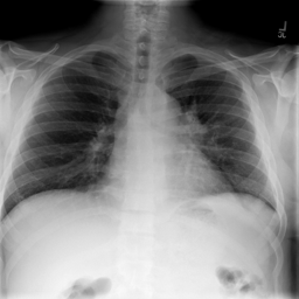

In [ ]:
img.convert('RGB')

In [ ]:
transform = transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])

In [ ]:
img_tensor = transform(img)

In [ ]:
img_tensor.shape

torch.Size([1, 50, 50])

In [ ]:
img_tensor.view(1,1,50,50).shape

torch.Size([1, 1, 50, 50])

In [ ]:
!ls

 covid			     Normal.metadata.csv
 COVID.metadata.csv	     opacidade
 Lung_Opacity.metadata.csv   viral
 normal			    'Viral Pneumonia.metadata.csv'


# **Criação das Classes**

In [ ]:
for file_names in os.scandir('./'):
    print(file_names)

<DirEntry 'COVID.metadata.csv'>
<DirEntry 'Lung_Opacity.metadata.csv'>
<DirEntry 'Normal.metadata.csv'>
<DirEntry 'Viral Pneumonia.metadata.csv'>
<DirEntry 'covid'>
<DirEntry 'opacidade'>
<DirEntry 'viral'>
<DirEntry 'normal'>


In [ ]:
dir = './'

In [ ]:
classes = [d.name for d in os.scandir(dir) if d.is_dir()]

In [ ]:
classes

['covid', 'opacidade', 'viral', 'normal']

In [ ]:
classes.sort()
class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
class_to_idx

{'covid': 0, 'normal': 1, 'opacidade': 2, 'viral': 3}

In [ ]:
instances = []
for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(dir, target_class)
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                item = path, class_index
                instances.append(item)

In [ ]:
instances

[('./covid/COVID-1.png', 0),
 ('./covid/COVID-10.png', 0),
 ('./covid/COVID-100.png', 0),
 ('./covid/COVID-1000.png', 0),
 ('./covid/COVID-1001.png', 0),
 ('./covid/COVID-1002.png', 0),
 ('./covid/COVID-1003.png', 0),
 ('./covid/COVID-1004.png', 0),
 ('./covid/COVID-1005.png', 0),
 ('./covid/COVID-1006.png', 0),
 ('./covid/COVID-1007.png', 0),
 ('./covid/COVID-1008.png', 0),
 ('./covid/COVID-1009.png', 0),
 ('./covid/COVID-101.png', 0),
 ('./covid/COVID-1010.png', 0),
 ('./covid/COVID-1011.png', 0),
 ('./covid/COVID-1012.png', 0),
 ('./covid/COVID-1013.png', 0),
 ('./covid/COVID-1014.png', 0),
 ('./covid/COVID-1015.png', 0),
 ('./covid/COVID-1016.png', 0),
 ('./covid/COVID-1017.png', 0),
 ('./covid/COVID-1018.png', 0),
 ('./covid/COVID-1019.png', 0),
 ('./covid/COVID-102.png', 0),
 ('./covid/COVID-1020.png', 0),
 ('./covid/COVID-1021.png', 0),
 ('./covid/COVID-1022.png', 0),
 ('./covid/COVID-1023.png', 0),
 ('./covid/COVID-1024.png', 0),
 ('./covid/COVID-1025.png', 0),
 ('./covid/COVID

# **Criação do Data Set**

In [ ]:
from torch.utils.data import Dataset

from typing import Any,Tuple

class PulmoesDataset(Dataset):
    def __init__(self,dir,transform=None,target_transform=None,loader = None):
        self.main_dir = dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        self.classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.instances = self.make_instances()
        self.loader = loader
        if loader is None:
            self.loader = lambda x: Image.open(x).convert('RGB')

    def make_instances(self):
        instances = []
        for target_class in sorted(self.class_to_idx.keys()):
                class_index = self.class_to_idx[target_class]
                target_dir = os.path.join(self.main_dir, target_class)
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        item = path, class_index
                        instances.append(item)
        return instances
    def __getitem__(self,index:int) -> Tuple[Any,Any]:
        path, target = self.instances[index] #path, target = atributo classe
        instance = self.loader(path)
        if self.transform is not None:
            instance = self.transform(instance)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return instance,target
    def __len__(self) -> int:
        return len(self.instances)

In [ ]:
dataset = PulmoesDataset('./',transform=transform)

In [ ]:
len(dataset)

21165

In [ ]:
dl = DataLoader(dataset,batch_size=1024)

In [ ]:
data,class_att = next(iter(dl))

In [ ]:
data.shape

torch.Size([1024, 3, 50, 50])

In [ ]:
class_att.shape

torch.Size([1024])

In [ ]:
grid_img = torchvision.utils.make_grid(data,nrow=45)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


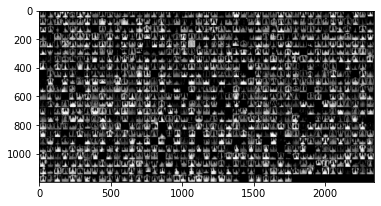

In [ ]:
plt.imshow(grid_img.permute(1,2,0))

# **Criação e Ajuste Fino do Modelo Shufflenet v2 x0.5**

In [ ]:
model = torchvision.models.shufflenet_v2_x0_5(pretrained=True)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth


In [ ]:
model.fc = nn.Linear(1024, 4)

In [ ]:
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

# **Split**

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
#Tentei fazer com stratify, mas demorou 1h para executar e retornou o seguinte erro:
#ValueError: only one element tensors can be converted to Python scalars
#como as classes são suficientemente grandes, consegui obter uma boa taxa de aprendizagem mesmo sem stratify
train_idx, temp_idx = train_test_split(np.arange(len(dataset)),test_size=0.3,shuffle=True)

In [ ]:
len(train_idx),len(temp_idx)

(14815, 6350)

In [ ]:
valid_idx, test_idx = train_test_split(temp_idx,test_size=0.5,shuffle=True)

In [ ]:
len(valid_idx),len(test_idx)

(3175, 3175)

In [ ]:
valid_idx

array([  896, 16245,  5301, ...,   311,  6334, 18040])

In [ ]:
bs = 1024
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler  = torch.utils.data.SubsetRandomSampler(test_idx)

dl_train = torch.utils.data.DataLoader(dataset,batch_size=bs,sampler=train_sampler)
dl_valid = torch.utils.data.DataLoader(dataset,batch_size=bs,sampler=valid_sampler)
dl_test  = torch.utils.data.DataLoader(dataset,batch_size=bs,sampler=test_sampler)

# **Otimização**

In [ ]:
import torch.optim as optim

In [ ]:
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(),lr=0.2)

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

# **Treino**

In [ ]:
epochs = 15

In [ ]:
#1h 23mins de processamento
for epoch in range(epochs):
    model.train()
    lloss = []
    for x,y in dl_train:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        closs = criterion(pred,y)
        closs.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(closs.item())
        #print(closs.item())
    print("epoch %d media %4.3f"%(epoch,np.mean(lloss)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch 0 media 1.259
epoch 1 media 1.129
epoch 2 media 1.052
epoch 3 media 0.975
epoch 4 media 0.890
epoch 5 media 0.825
epoch 6 media 0.762
epoch 7 media 0.699
epoch 8 media 0.617
epoch 9 media 0.526
epoch 10 media 0.449
epoch 11 media 0.402
epoch 12 media 0.363
epoch 13 media 0.334
epoch 14 media 0.309


# **Teste e Avaliação**

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import  accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#11 mins de processamento
model.eval()
lres = []
ytrue = []
with torch.no_grad():
    for data,target in dl_test:
        data = data.to(device)
        pred = model(data)
        res  = pred.argmax(dim=1).cpu().tolist()
        lres += res
        ytrue += target

In [ ]:
target_names = ['Covid', 'Normal', 'Opacidade', 'Viral']
print("Modelo B -  Shufflenet V2 x0 5")
print("\n")
print(classification_report(ytrue, lres, target_names=target_names))
matriz_conf = metrics.confusion_matrix(ytrue,lres)
print("Matriz Confusa: \n", matriz_conf)

Modelo B -  Shufflenet V2 x0 5


              precision    recall  f1-score   support

       Covid       0.82      0.89      0.85       564
      Normal       0.89      0.86      0.87      1508
   Opacidade       0.82      0.82      0.82       907
       Viral       0.91      0.86      0.89       196

    accuracy                           0.86      3175
   macro avg       0.86      0.86      0.86      3175
weighted avg       0.86      0.86      0.86      3175

Matriz Confusa: 
 [[ 501   31   30    2]
 [  63 1301  132   12]
 [  41  120  744    2]
 [   5   18    4  169]]


# **Gráficos**

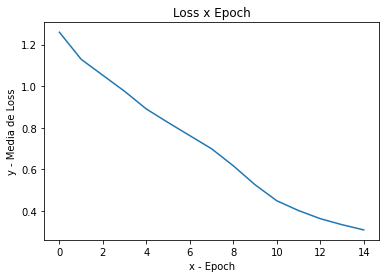

In [ ]:
import matplotlib.pyplot as plt
  
x = [0,1,2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
y = [1.259, 1.129, 1.052, 0.975, 0.890, 0.825, 0.762, 0.699, 0.617, 0.526, 0.449, 0.402, 0.363, 0.334, 0.309]

plt.plot(x, y)
  
plt.xlabel('x - Epoch')
plt.ylabel('y - Media de Loss')
plt.title('Loss x Epoch')

plt.show()